# Summary (TLDR)

Method: stacked LSTM to forecast.
I found that:

    1) Global Power In(GPI) can be forecasted as a stand-alone time series since it does not depend on VPS system. It might depend on utility service (PG&E,..)
    
    2) Global Power Out(GPO) is too bumpy to have a good forecast to track all the spikes, so forecast lines are very close to a smooth average.
    
    3) Difference between GPI and GPO can have a good forecast. It also benefits from adding other variables e.g voltage, intensity, room metters.
    
    4) There is potential to improve on forecast error with increase number of epochs and finetune model architecture. Most of loss curve are not flat yet.


In [1]:
from IPython.display import clear_output
try:
  !pip install tensorflow==2.0.0-beta1
except:
  pass
finally:
  clear_output()
  print('All Loaded')

All Loaded


Install Tensorflow 2.0 and import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
print(tf.__version__)

/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/dty

2.0.0-beta1


/usr/local/envs/py3env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/envs/py3env/lib/python3.5/site-packages/tensorboar

In [4]:
#uploaded = files.upload()

Saving power_consumption_data.txt.zip to power_consumption_data.txt.zip


Read data from zip file into a dataframe:

In [2]:
with zipfile.ZipFile("power_consumption_data.txt.zip") as z:
   with z.open("power_consumption_data.txt") as f:
      raw_data = pd.read_csv(f,delimiter=';')
     

/usr/local/envs/py3env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_data.head()
     

Date      Time Global_power_in Global_power_out  Voltage  \
0  16/12/2006  17:24:00           4.216            0.418  234.840   
1  16/12/2006  17:25:00           5.360            0.436  233.630   
2  16/12/2006  17:26:00           5.374            0.498  233.290   
3  16/12/2006  17:27:00           5.388            0.502  233.740   
4  16/12/2006  17:28:00           3.666            0.528  235.680   

  Global_intensity metering_1 metering_2  metering_3  
0           18.400      0.000      1.000        17.0  
1           23.000      0.000      1.000        16.0  
2           23.000      0.000      2.000        17.0  
3           23.000      0.000      1.000        17.0  
4           15.800      0.000      1.000        17.0

In [5]:
raw_data.dtypes

Date                 object
Time                 object
Global_power_in      object
Global_power_out     object
Voltage              object
Global_intensity     object
metering_1           object
metering_2           object
metering_3          float64
dtype: object

From the above result we see that all the features in object type, so we need to convert these features (except Date and Time) into numeric type:

In [4]:
raw_data[['Global_power_in', 'Global_power_out','Voltage','Global_intensity','metering_1','metering_2','metering_3']]=\
    raw_data[['Global_power_in', 'Global_power_out','Voltage','Global_intensity','metering_1','metering_2','metering_3']]\
    .apply(pd.to_numeric,errors='coerce')

In [7]:
raw_data.describe()

Global_power_in  Global_power_out       Voltage  Global_intensity  \
count     2.049280e+06      2.049280e+06  2.049280e+06      2.049280e+06   
mean      1.091615e+00      1.237145e-01  2.408399e+02      4.627759e+00   
std       1.057294e+00      1.127220e-01  3.239987e+00      4.444396e+00   
min       7.600000e-02      0.000000e+00  2.232000e+02      2.000000e-01   
25%       3.080000e-01      4.800000e-02  2.389900e+02      1.400000e+00   
50%       6.020000e-01      1.000000e-01  2.410100e+02      2.600000e+00   
75%       1.528000e+00      1.940000e-01  2.428900e+02      6.400000e+00   
max       1.112200e+01      1.390000e+00  2.541500e+02      4.840000e+01   

         metering_1    metering_2    metering_3  
count  2.049280e+06  2.049280e+06  2.049280e+06  
mean   1.121923e+00  1.298520e+00  6.458447e+00  
std    6.153031e+00  5.822026e+00  8.437154e+00  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  1.000000e+00  
75%    0.000000e+00  1.000000e+00  1.700000e+01  
max    8.800000e+01  8.000000e+01  3.100000e+01

In [6]:
#import pdb; pdb.pm()

Below is the plot of Global_power_in and Date. This plot does not show clearly how Power_in change over year.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


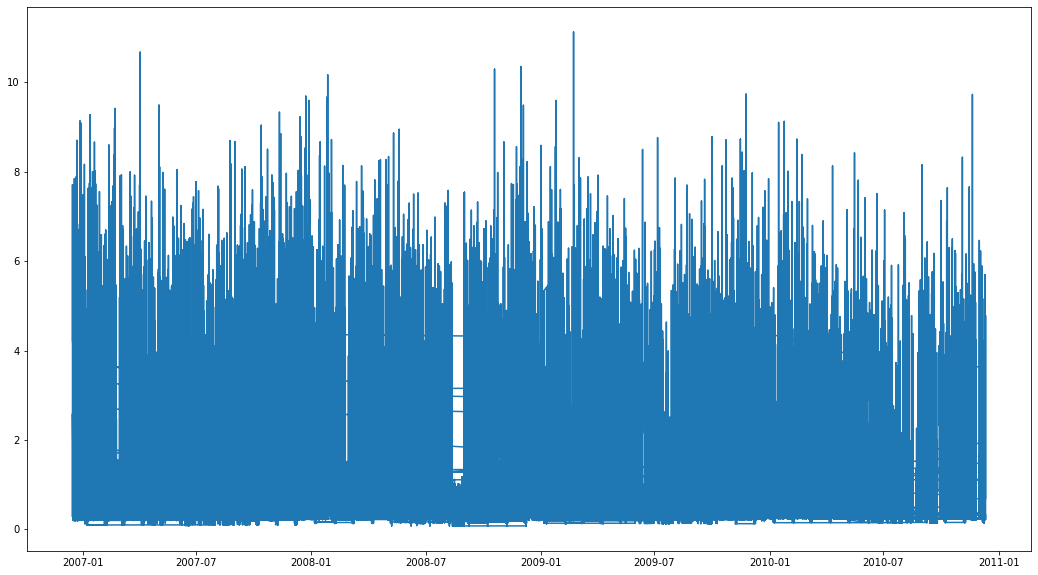

In [0]:
plt.figure(figsize=(18,10))
plt.plot(raw_data.Date,raw_data.Global_power_in)

The below plot shows the average Global power in vs time of a day.

In [ ]:
avg_power = raw_data.groupby('Time').mean()

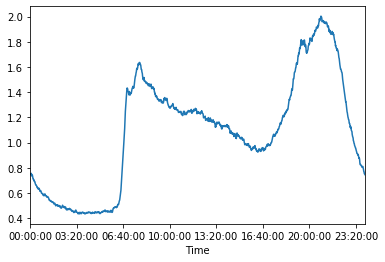

In [0]:
avg_power['Global_power_in'].plot()

The below plot show the average Global power out vs time of a day.

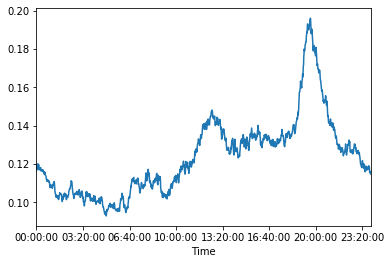

In [0]:
avg_power['Global_power_out'].plot()

The below plots show the voltage and the difference b/t Global Power in and out vs time of the day. We can see that there are negative correlated b/t the difference b/t Global Power in - out and voltage.

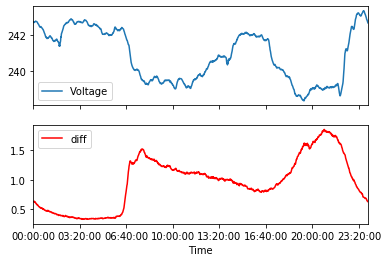

In [0]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True)
avg_power.plot( y = 'Voltage',ax = axes[0])
avg_power['diff'] = avg_power['Global_power_in']-avg_power['Global_power_out']
avg_power.plot(y = 'diff', color='red',ax = axes[1])

Below is a plot of all variables vs time of a day.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f43909bf5c0>,
      dtype=object)

<Figure size 2160x2160 with 0 Axes>

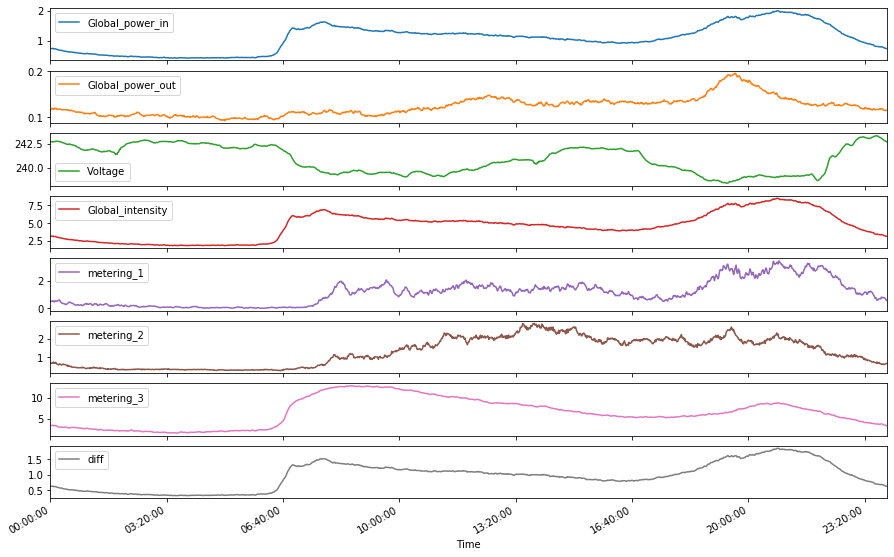

In [0]:
plt.figure(figsize=(30,30))
avg_power.plot(subplots=True, sharex=True,figsize=(15,10))

Check the missing values in GPI and GPO columns, there are missing values in these two columns.

In [5]:
print(np.count_nonzero(~np.isnan(raw_data['Global_power_in'])),len(raw_data['Global_power_in']))
print(np.count_nonzero(~np.isnan(raw_data['Global_power_out'])),len(raw_data['Global_power_out']))

2049280 2075259
2049280 2075259


Using fill forward method to imputate the missing values in GPI and GPO columns.

In [6]:
raw_data['Global_power_in'].fillna(method = 'pad', inplace=True)
raw_data['Global_power_out'].fillna(method = 'pad', inplace=True)

In our data, observations was recorded every minute. I will aggregate them into hourly. The cell below is to extract hour in Time column:

In [7]:
raw_data['Time_hour'] = raw_data['Time'].apply(lambda x: x[0:2])


 Take the difference b/t GPI and GPO:

In [8]:
raw_data['Diff_gpi_gpo']= raw_data['Global_power_in'] - raw_data['Global_power_out']

Using groupby function to sum values based on hour.

In [9]:
avg_power = raw_data.groupby(['Date','Time_hour']).sum()
avg_power.head()
gpi_data = avg_power.sort_index()['Global_power_in']
gpo_data = avg_power.sort_index()['Global_power_out']

In [69]:
gpo_data.shape
avg_power.head()

Global_power_in  Global_power_out     Voltage  \
Date     Time_hour                                                  
1/1/2007 00                 153.038             6.768  241.361333   
         01                 151.404             4.298  241.096500   
         02                 154.940             6.400  243.200167   
         03                 152.500             5.406  243.265667   
         04                 148.544             5.290  242.456167   

                    Global_intensity  metering_1  metering_2  metering_3  \
Date     Time_hour                                                         
1/1/2007 00                10.530000         0.0        35.0         0.0   
         01                10.443333         0.0         0.0         0.0   
         02                10.540000         0.0        20.0         0.0   
         03                10.400000         0.0        16.0         0.0   
         04                10.110000         0.0         0.0         0.0   

                    Diff_gpi_gpo  
Date     Time_hour                
1/1/2007 00              146.270  
         01              147.106  
         02              148.540  
         03              147.094  
         04              143.254

After aggregating the data into hour, we have around 34500 rows, I am using 30000 values to train and the rest for validation.

In [30]:
TRAIN_SPLIT = 30000
tf.random.set_seed(13)

Using MinmaxScaler in sklearn to scale the data in GPI and GPO columns.

In [12]:
# Feature Scaling for GPI data
from sklearn.preprocessing import MinMaxScaler
sc_gpi = MinMaxScaler(feature_range = (0, 1))
gpi_data_scaled = sc_gpi.fit_transform(gpi_data.reshape(-1, 1))
gpi_data_scaled.shape

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(34589, 1)

In [31]:
# Feature Scaling for GPO data
sc_gpo = MinMaxScaler(feature_range = (0, 1))
gpo_data_scaled = sc_gpo.fit_transform(gpo_data.reshape(-1, 1))
gpo_data_scaled.shape

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


(34589, 1)

Plot last 100 points in GPI data (after aggregating by hour) to explore the time series, we can see that the values are very fluctuated, and doesn't follow the particular pattern. 

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


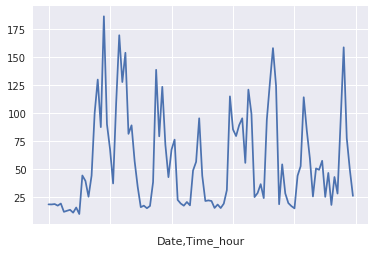

In [137]:
gpi_data.tail(100).plot()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


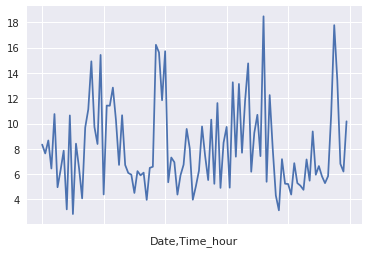

In [138]:
gpo_data.tail(100).plot()

Below are the functions to create the time steps and plot the history, true future values and predicted values:

In [20]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [35]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(20, 6))
  history = history[-(7*24):]
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'b-',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r-',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

Since I aggregated our data into hour, so each day we will have 24 observations. Given a specific time, If I want to predict GPI for 1 day ahead using 28 days of observations.Then, I would create a window containing the last 28 days (28* 24) observations to train the model.
The function below returns the windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Use the above function to create data input for the model.

In [23]:
HOURS_DAY = 24
history_window_size = 28
target_size = 1
past_history = HOURS_DAY*history_window_size
future_target = HOURS_DAY*target_size

x_train_gpi, y_train_gpi = multivariate_data(gpi_data_scaled, gpi_data_scaled[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_gpi, y_val_gpi = multivariate_data(gpi_data_scaled, gpi_data_scaled[:,0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [34]:
print ('Single window of past history : {}'.format(x_train_gpi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_gpi[0].shape))



Single window of past history : (672, 1)

 Target temperature to predict : (24,)


Use multi_step_plot function to plot second past historical windown and second target windown of GPI data.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


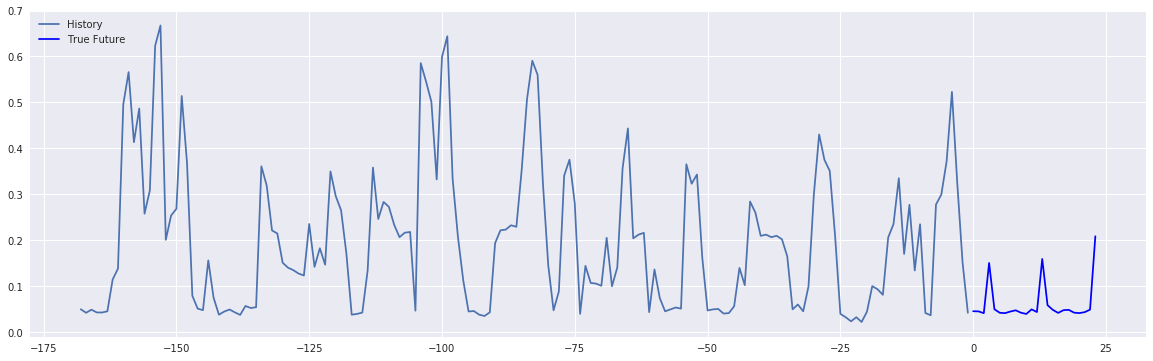

In [144]:
multi_step_plot(x_train_gpi[1], y_train_gpi[1], np.array([0]))

The below function is LSTM model architecture, we can use this function if we have GPU to train on. In this experiment, I don't train the model on GPU.Instead, we will train our model with the next function.

In [24]:
def create_model_with_gpu(input_shape, horizon):
  strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.LSTM(16, activation='relu'))
    model.add(tf.keras.layers.Dense(horizon))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return model

Below is the LSTM model architecture in the create_model function that to be used  to train our data. The model consists of two LSTM layers. We will use future_target size = 24 as the dense layer outputs of 24 predictions. I tried many different optimizers function such as sgd, adam and Rmsprop, and Rmsprop produce the smallest loss error. Loss function I use here is mean absolute error.

In [57]:
def create_model(input_shape, horizon):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(tf.keras.layers.LSTM(16, activation='relu'))
  model.add(tf.keras.layers.Dense(horizon))
  #model.compile(optimizer = 'adam', loss = 'mae')
  model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return model

In [58]:
multi_step_model = create_model(input_shape=x_train_gpi.shape[-2:], horizon=gpi_future_target)

In [46]:
multi_step_model.predict(x_val_gpi).shape

(3893, 24)

Use tf.data.Dataset to build the tensorflow input pipelines,to shuffle, batch, and cache the dataset:

In [59]:
BATCH_SIZE = 250
BUFFER_SIZE = 10000
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_gpi, y_train_gpi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_gpi, y_val_gpi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Now we are already to fit the model with our GPI train and validation data.

In [60]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=20,
                                          steps_per_epoch=200,
                                          use_multiprocessing=True,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20
200/200 [==============================] - 188s 938ms/step - loss: 0.1111 - val_loss: 0.0992
Epoch 2/20
200/200 [==============================] - 181s 906ms/step - loss: 0.1031 - val_loss: 0.0960
Epoch 3/20
200/200 [==============================] - 180s 901ms/step - loss: 0.0984 - val_loss: 0.0890
Epoch 4/20
200/200 [==============================] - 182s 911ms/step - loss: 0.0937 - val_loss: 0.0838
Epoch 5/20
200/200 [==============================] - 188s 938ms/step - loss: 0.0909 - val_loss: 0.0835
Epoch 6/20
200/200 [==============================] - 185s 927ms/step - loss: 0.0888 - val_loss: 0.0812
Epoch 7/20
200/200 [==============================] - 182s 909ms/step - loss: 0.0881 - val_loss: 0.0806
Epoch 8/20
200/200 [==============================] - 178s 889ms/step - loss: 0.0871 - val_loss: 0.0807
Epoch 9/20
200/200 [==============================] - 179s 894ms/step - loss: 0.0874 - val_loss: 0.0806
Epoch 10/20
200/200 [==============================] - 180s 899m

The plot_train_history function below is to use to plot the loss error of training data and validation data vs number of epochs:

In [36]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Plot below shows that loss errors of training and validation data is still decreasing beyond 20 epochs. If I have more time or computation I will increase this number of epoch

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


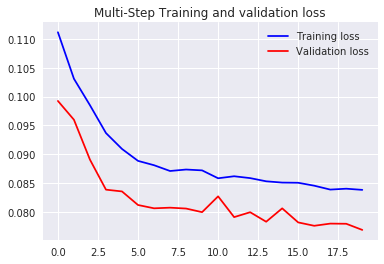

In [62]:
plot_train_history(multi_step_history, 'GPI Multi-Step Training and validation loss')

Below are the plot of true future and predicted future of three windowns of GPI.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


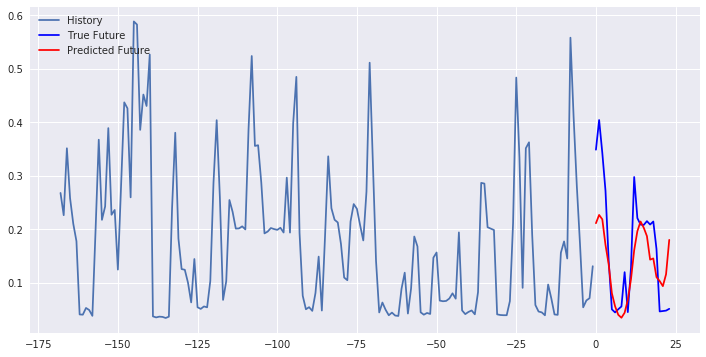

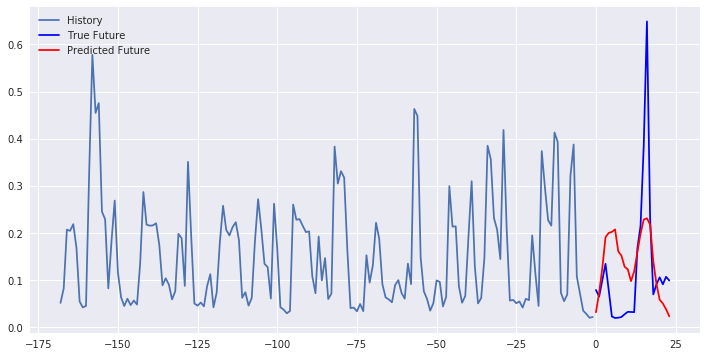

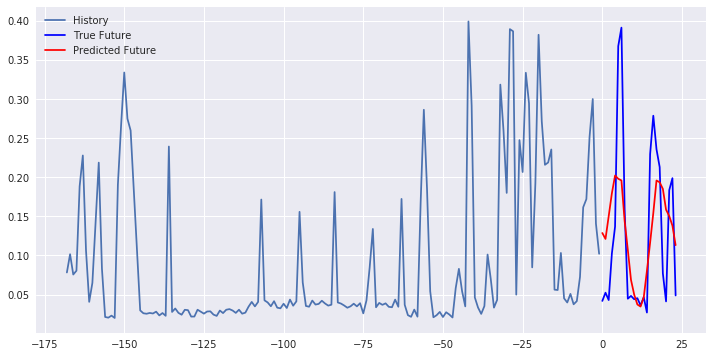

In [66]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])



Save the weights of the model.

In [67]:
multi_step_model.save_weights('./checkpoints/my_checkpoint')

In [68]:
#multi_step_model_new = create_model(input_shape=x_train_gpi.shape[-2:], horizon=gpi_future_target)

Summary of the model

In [69]:
multi_step_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 672, 32)           4352      
_________________________________________________________________
lstm_15 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                408       
Total params: 7,896
Trainable params: 7,896
Non-trainable params: 0
_________________________________________________________________


In [102]:
multi_step_model.load_weights('./checkpoints/my_checkpoint')

In [137]:
#multi_step_history = multi_step_model_new.fit(train_data_multi, epochs=1,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

100/100 [==============================] - 78s 782ms/step - loss: 0.0760 - val_loss: 0.0805


In order to reuse the model, we can save the model and reload it later.

In [104]:
multi_step_model.save('gpiv2.h5')

In [105]:
loss = multi_step_model_new.evaluate(x_val_gpi, y_val_gpi, verbose=2)
print('Model error, MAE: {:5.4f}'.format(loss))

3893/3893 - 13s - loss: 0.0774
Model error, MAE: 0.0774


In [107]:
# Recreate the exact same model, including its weights and the optimizer
restored_model_gpi = tf.keras.models.load_model('gpiv2.h5')

# Forecast Global_power_out (GPO):

In this prediction, we will use the historical data of GPO to forecast future data. The folllowing process repeat the whole process of prediction GPI above.

In [150]:
x_train_gpo, y_train_gpo = multivariate_data(gpo_data_scaled, gpo_data_scaled[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_gpo, y_val_gpo = multivariate_data(gpo_data_scaled, gpo_data_scaled[:,0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [146]:
print ('Single window of past history : {}'.format(x_train_gpi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_gpi[0].shape))

Single window of past history : (672, 1)

 Target temperature to predict : (24,)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


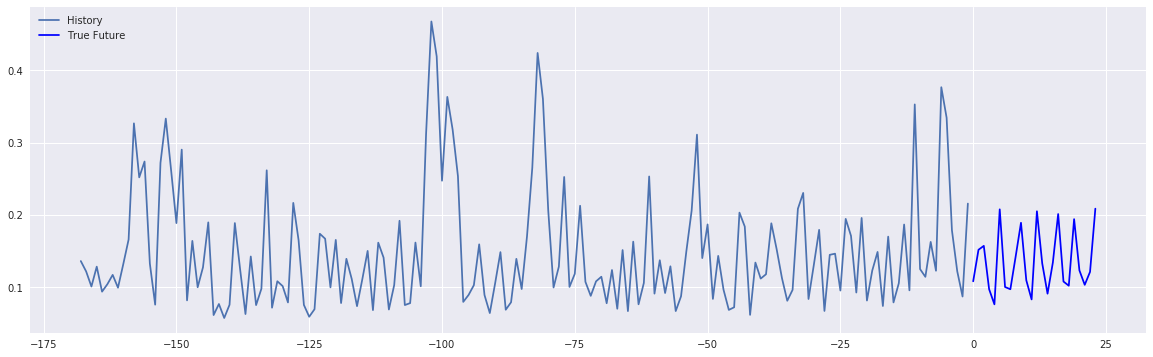

In [151]:
multi_step_plot(x_train_gpo[0], y_train_gpo[0], np.array([0]))

In [158]:
def create_model(input_shape, horizon):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(tf.keras.layers.LSTM(16, activation='relu'))
  model.add(tf.keras.layers.Dense(horizon))
  #model.compile(optimizer = 'adam', loss = 'mae')
  model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return model

In [160]:
multi_step_model_gpo = create_model(input_shape=x_train_gpo.shape[-2:], horizon=future_target)

In [161]:
BATCH_SIZE = 250
BUFFER_SIZE = 10000
train_data_multi_gpo = tf.data.Dataset.from_tensor_slices((x_train_gpo, y_train_gpo))
train_data_multi_gpo = train_data_multi_gpo.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_gpo = tf.data.Dataset.from_tensor_slices((x_val_gpo, y_val_gpo))
val_data_multi_gpo = val_data_multi_gpo.batch(BATCH_SIZE).repeat()

In [162]:
multi_step_history_gpo = multi_step_model_gpo.fit(train_data_multi_gpo, epochs=20,
                                          steps_per_epoch=200,
                                          use_multiprocessing=True,
                                          validation_data=val_data_multi_gpo,
                                          validation_steps=50)

Epoch 1/20
200/200 [==============================] - 194s 969ms/step - loss: 0.0672 - val_loss: 0.0582
Epoch 2/20
200/200 [==============================] - 185s 925ms/step - loss: 0.0606 - val_loss: 0.0567
Epoch 3/20
200/200 [==============================] - 183s 915ms/step - loss: 0.0603 - val_loss: 0.0563
Epoch 4/20
200/200 [==============================] - 184s 919ms/step - loss: 0.0598 - val_loss: 0.0559
Epoch 5/20
200/200 [==============================] - 182s 910ms/step - loss: 0.0590 - val_loss: 0.0556
Epoch 6/20
200/200 [==============================] - 186s 932ms/step - loss: 0.0587 - val_loss: 0.0561
Epoch 7/20
200/200 [==============================] - 190s 950ms/step - loss: 0.0583 - val_loss: 0.0545
Epoch 8/20
200/200 [==============================] - 190s 950ms/step - loss: 0.0576 - val_loss: 0.0552
Epoch 9/20
200/200 [==============================] - 190s 948ms/step - loss: 0.0572 - val_loss: 0.0540
Epoch 10/20
200/200 [==============================] - 188s 939m

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


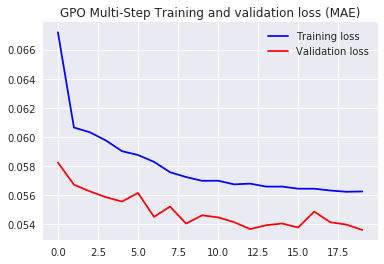

In [166]:
plot_train_history(multi_step_history_gpo, 'GPO Multi-Step Training and validation loss (MAE)')

In [177]:
multi_step_model_gpo.save('gpov1.h5')

In [174]:
loss = multi_step_model_gpo.evaluate(x_val_gpo, y_val_gpo, verbose=2)
print('Model error, MAE: {:5.4f}'.format(loss))

3893/3893 - 31s - loss: 0.0534
Model error, MAE: 0.0534


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


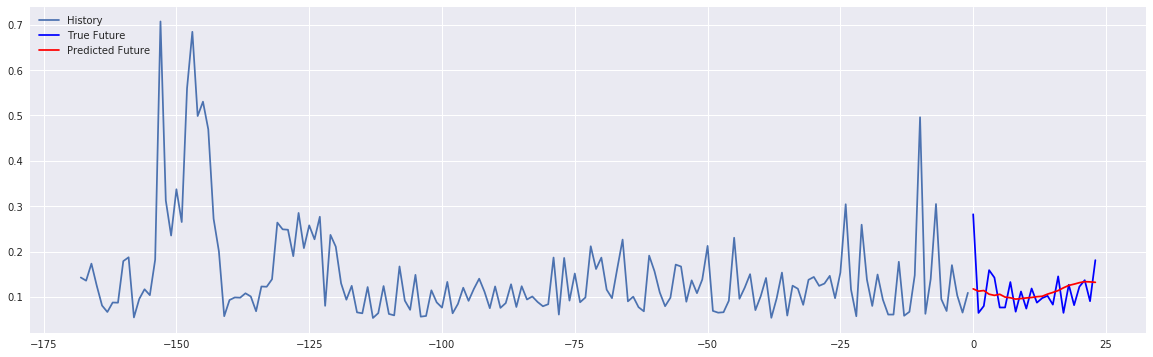

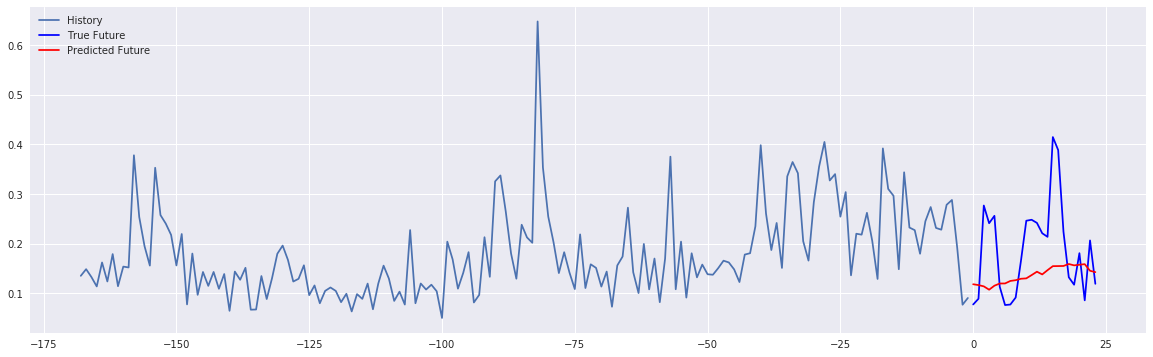

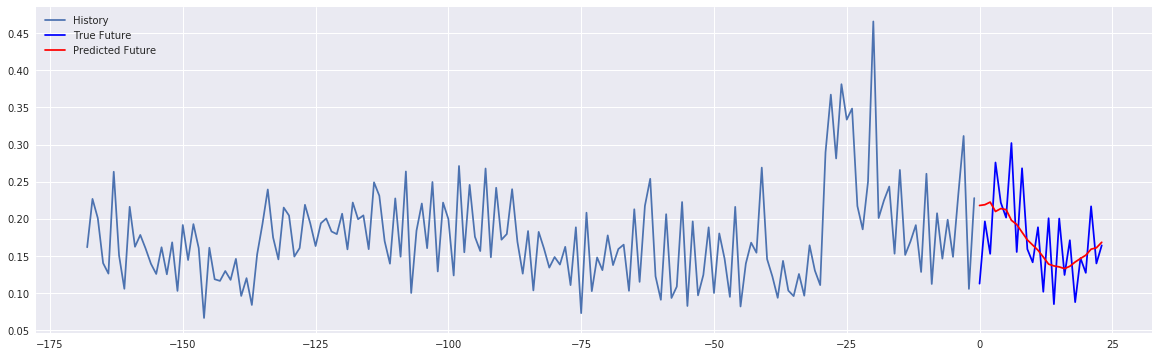

In [167]:
for x, y in val_data_multi_gpo.take(3):
  multi_step_plot(x[0], y[0], multi_step_model_gpo.predict(x)[0])

The result shows that we cannot predict the GPO bumpy pattern based on it historical data. Model chooses to provide a smooth forecast instead.
Next step, I will take the difference b/t GPI and GPO as a power usage of the system , and forecast the difference.

# Forecast power usage of the system

Create the data called diff_power by taking the column from the difference of GPI and GPO. In this section, the whole process is similar to the process of forecasting GPI. The only difference is in this model is that adam optimizer function work better than rmsprop.

In [164]:
diff_power = avg_power.sort_index()['Diff_gpi_gpo']
diff_power.head()


Date      Time_hour
1/1/2007  00           146.270
          01           147.106
          02           148.540
          03           147.094
          04           143.254
Name: Diff_gpi_gpo, dtype: float64

In [165]:
# Feature Scaling for diff_power data
sc_diff = MinMaxScaler(feature_range = (0, 1))
diff_power_scaled = sc_diff.fit_transform(diff_power.reshape(-1, 1))
diff_power_scaled.shape

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(34589, 1)

In [168]:
x_train_diff_power, y_train_diff_power = multivariate_data(diff_power_scaled, diff_power_scaled[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_diff_power, y_val_diff_power = multivariate_data(diff_power_scaled, diff_power_scaled[:,0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [169]:
def create_model(input_shape, horizon):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(tf.keras.layers.LSTM(16, activation='relu'))
  model.add(tf.keras.layers.Dense(horizon))
  model.compile(optimizer = 'adam', loss = 'mae')
  #model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return model

In [170]:
multi_step_model_diff_power = create_model(input_shape=x_train_diff_power.shape[-2:], horizon=future_target)

In [171]:
BATCH_SIZE = 250
BUFFER_SIZE = 10000
train_data_multi_diff_power = tf.data.Dataset.from_tensor_slices((x_train_diff_power, y_train_diff_power))
train_data_multi_diff_power = train_data_multi_diff_power.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_diff_power = tf.data.Dataset.from_tensor_slices((x_val_diff_power, y_val_diff_power))
val_data_multi_diff_power = val_data_multi_diff_power.batch(BATCH_SIZE).repeat()

In [172]:
multi_step_history_diff_power = multi_step_model_diff_power.fit(train_data_multi_diff_power, epochs=20,
                                          steps_per_epoch=200,
                                          use_multiprocessing=True,
                                          validation_data=val_data_multi_diff_power,
                                          validation_steps=50)

Epoch 1/20
200/200 [==============================] - 188s 938ms/step - loss: 0.1123 - val_loss: 0.1004
Epoch 2/20
200/200 [==============================] - 182s 910ms/step - loss: 0.1048 - val_loss: 0.0985
Epoch 3/20
200/200 [==============================] - 179s 897ms/step - loss: 0.1015 - val_loss: 0.0926
Epoch 4/20
200/200 [==============================] - 180s 901ms/step - loss: 0.0927 - val_loss: 0.0843
Epoch 5/20
Epoch 5/20
Epoch 5/20
Epoch 5/20
Epoch 5/20
200/200 [==============================] - 180s 900ms/step - loss: 0.0938 - val_loss: 0.0952
Epoch 6/20
Epoch 6/20
Epoch 6/20
Epoch 6/20
Epoch 6/20
200/200 [==============================] - 181s 905ms/step - loss: 0.0952 - val_loss: 0.0855
Epoch 7/20
Epoch 7/20
Epoch 7/20
Epoch 7/20
Epoch 7/20
200/200 [==============================] - 182s 908ms/step - loss: 0.0907 - val_loss: 0.0832
Epoch 8/20
Epoch 8/20
Epoch 8/20
Epoch 8/20
Epoch 8/20
200/200 [==============================] - 181s 903ms/step - loss: 0.0894 - val_loss:

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


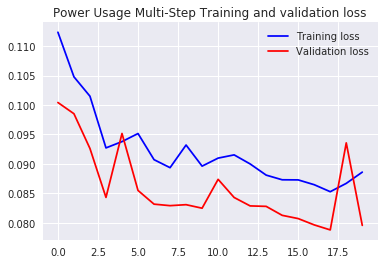

In [176]:
plot_train_history(multi_step_history_diff_power, 'Power Usage Multi-Step Training and validation loss')

In [223]:
loss = multi_step_model_diff_power.evaluate(x_val_diff_power, y_val_diff_power, verbose=2)
print('Model error, MAE: {:5.4f}'.format(loss))

3893/3893 - 30s - loss: 0.0802
Model error, MAE: 0.0802


Save model, including its weights and the optimizer for future usage and training

In [178]:
multi_step_model_diff_power.save('gpdiffv1.h5')

Recreate the exact same model, including its weights and the optimizer

In [184]:
# multi_step_model_diff_power = tf.keras.models.load_model('gpdiffv1.h5')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


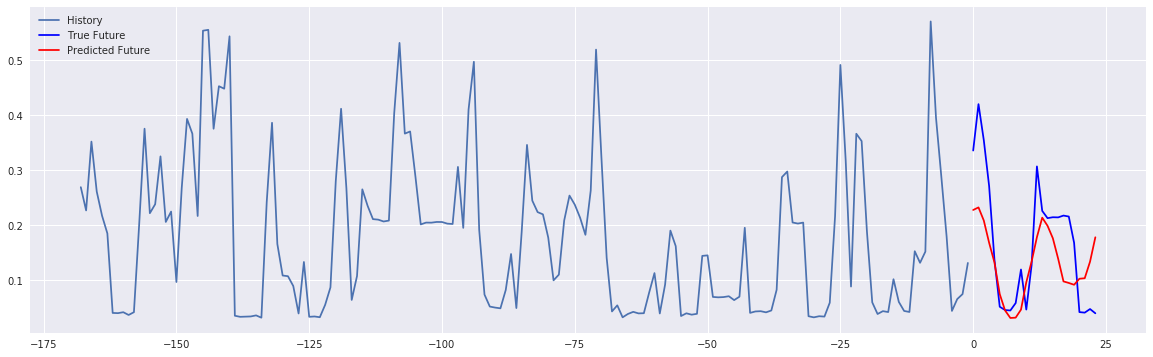

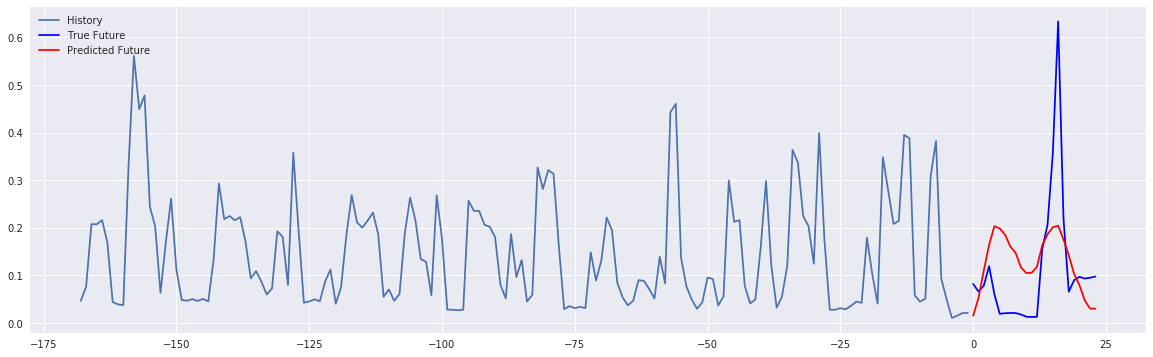

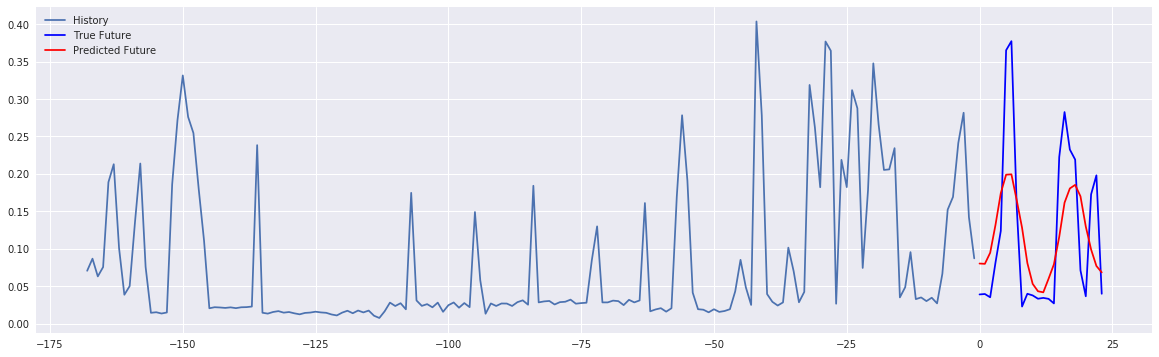

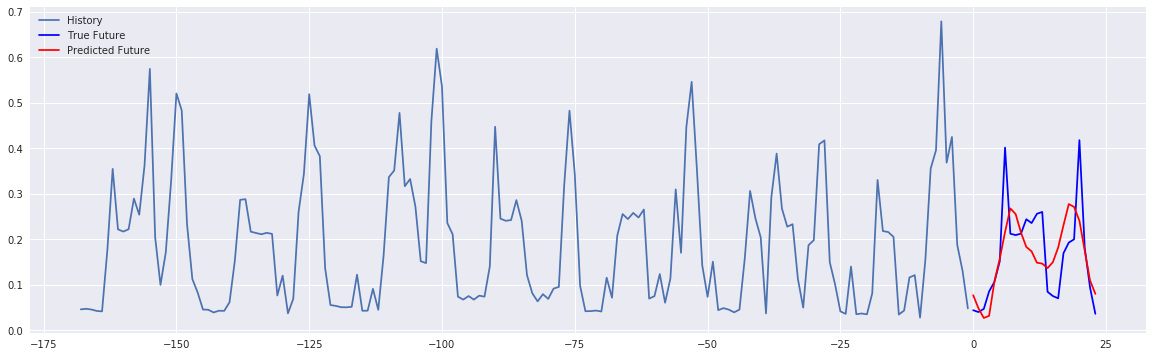

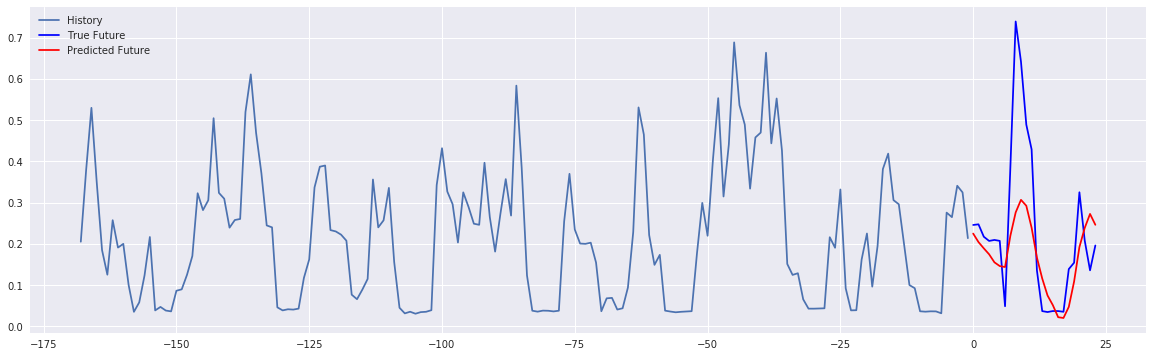

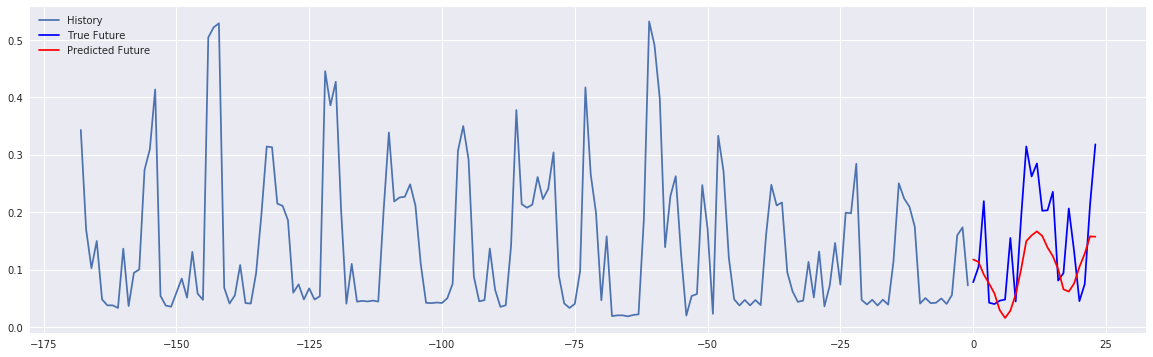

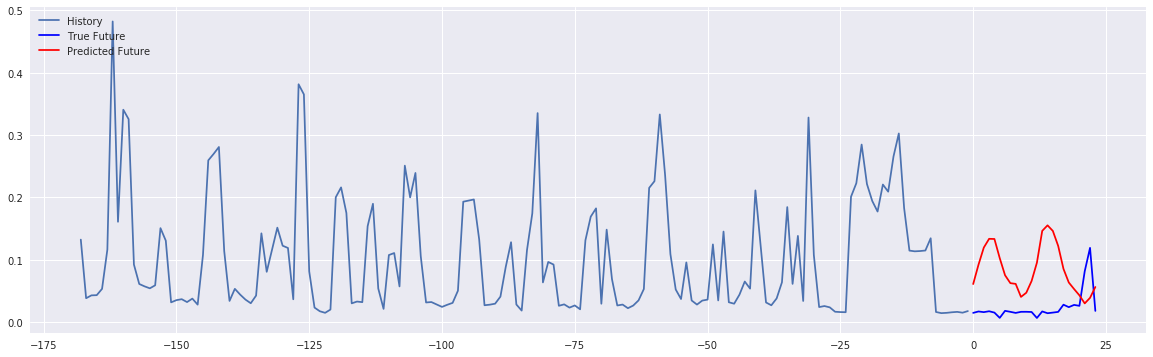

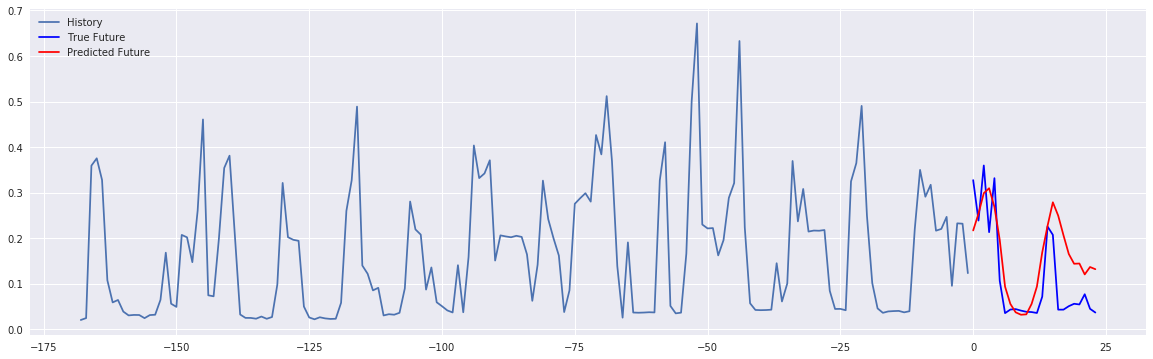

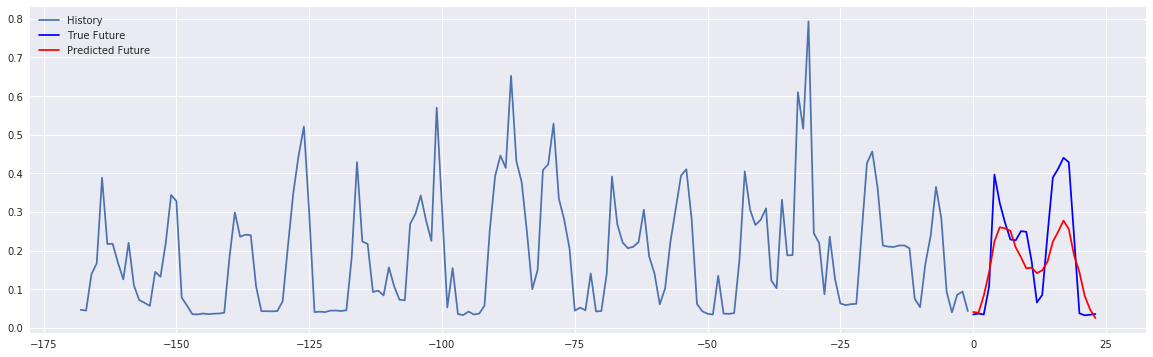

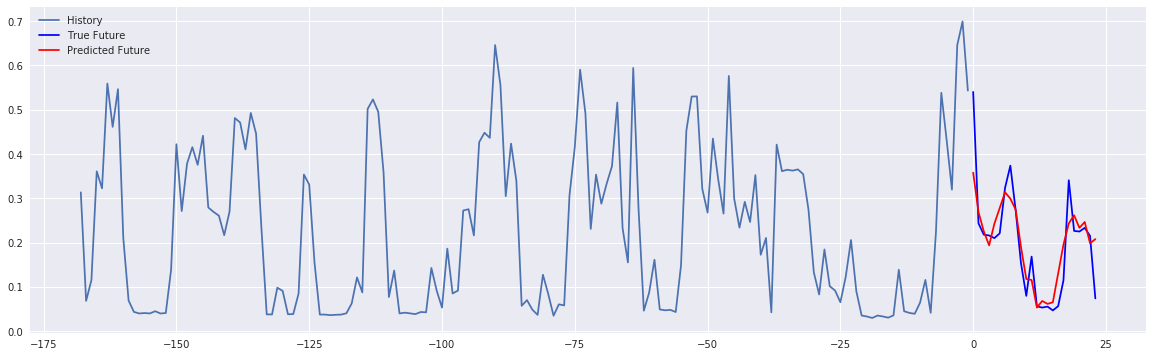

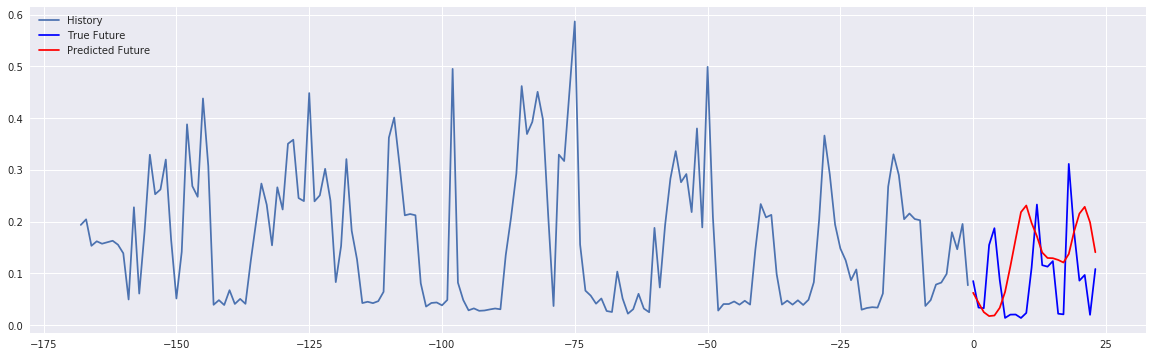

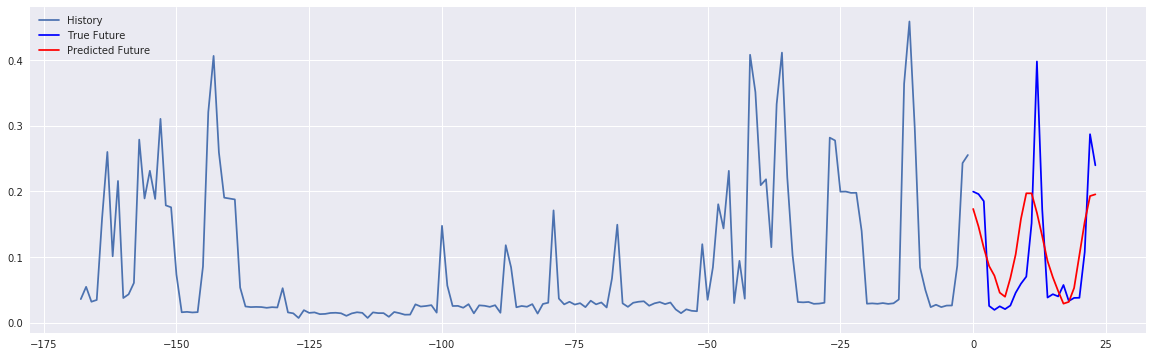

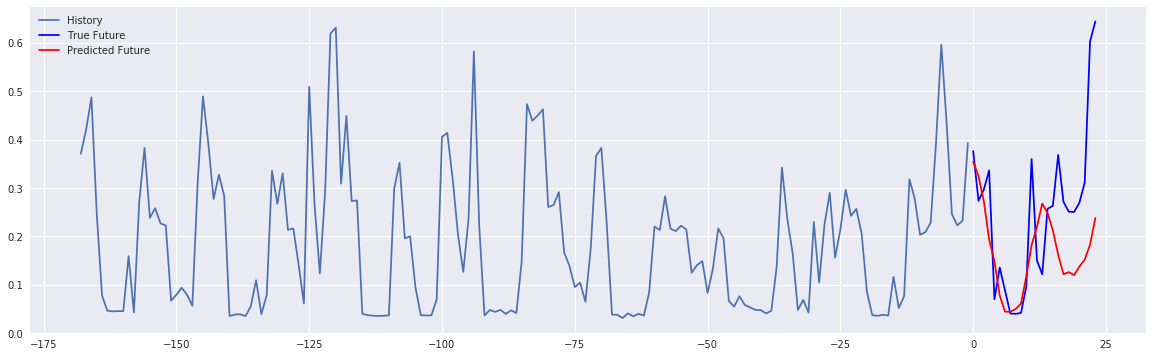

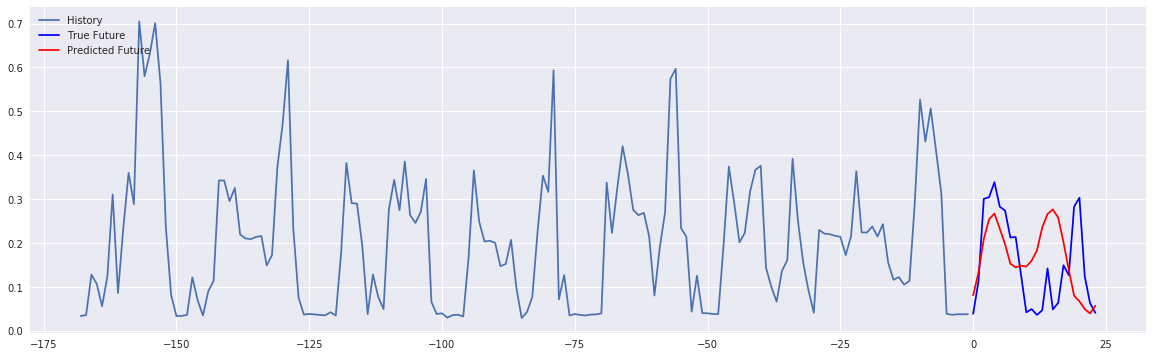

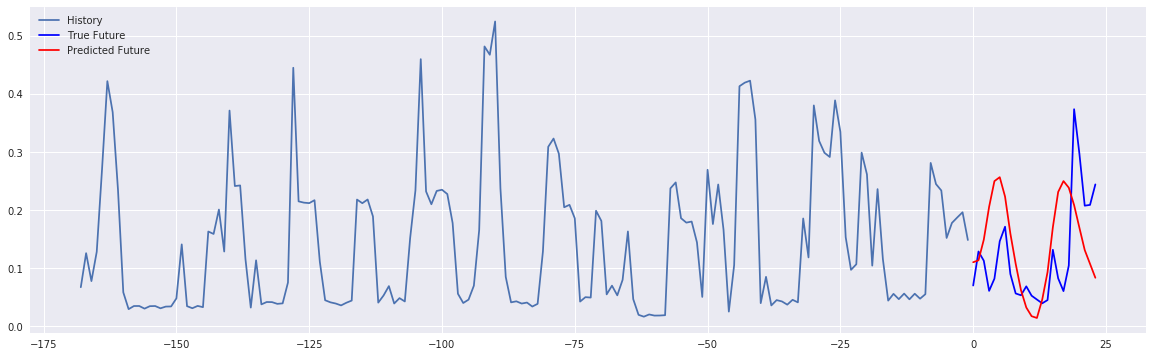

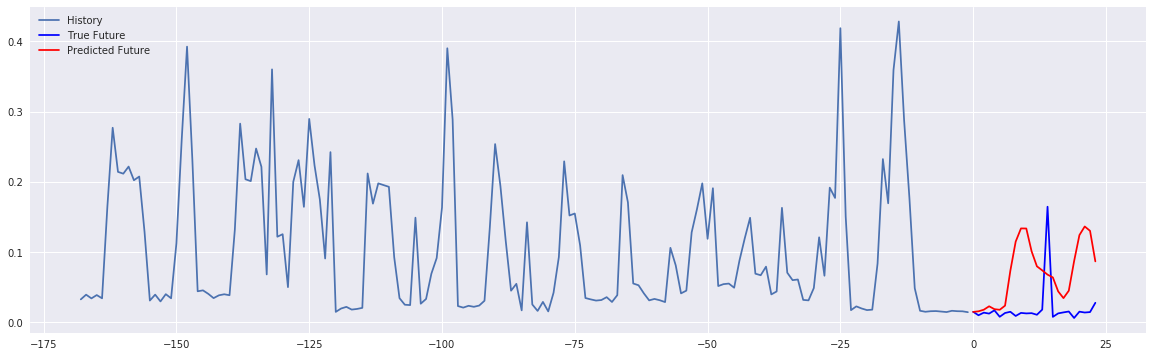

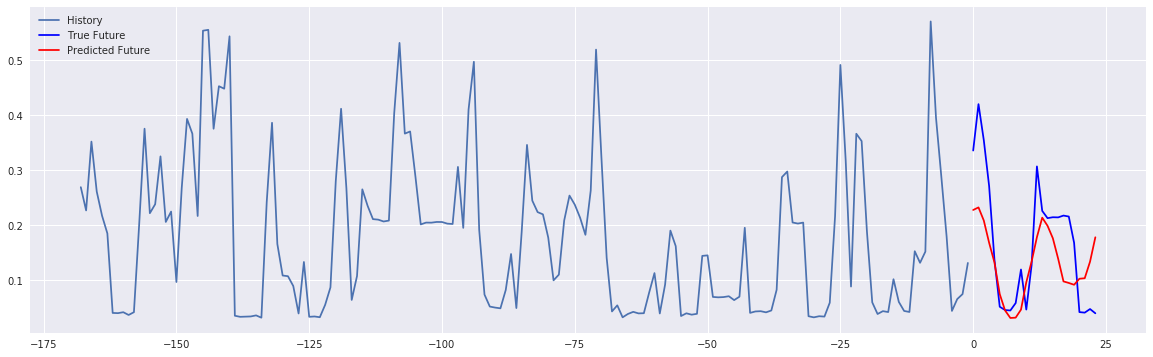

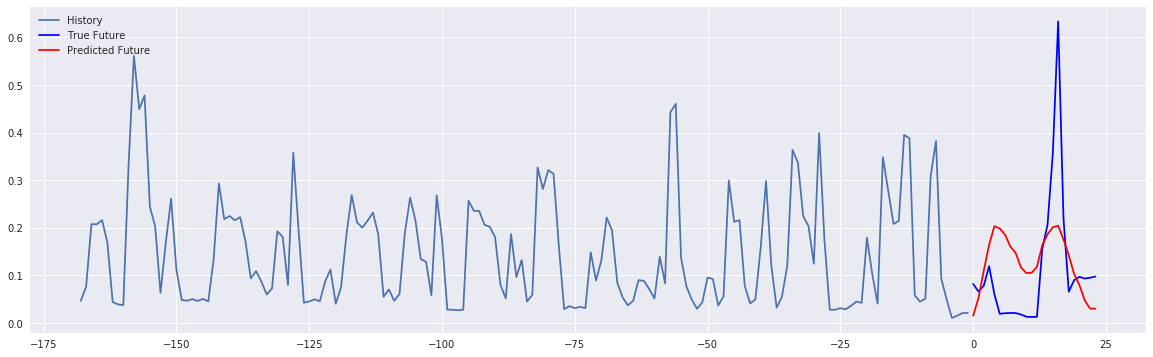

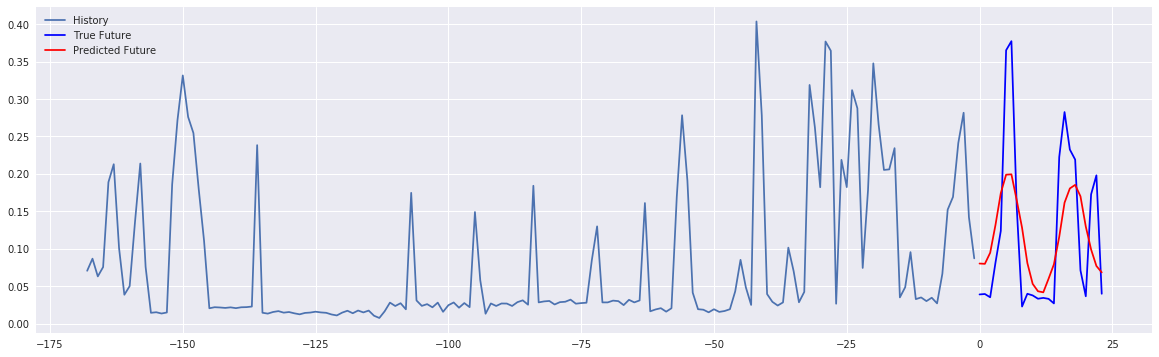

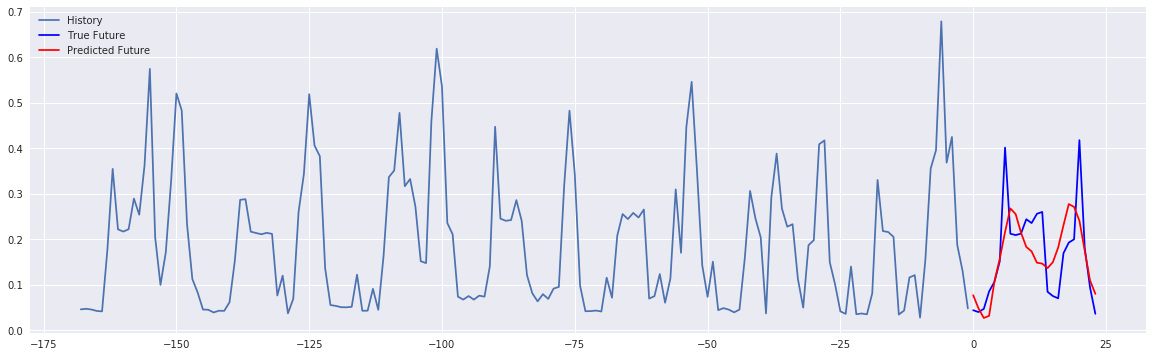

In [183]:
for x, y in val_data_multi_diff_power.take(20):
  multi_step_plot(x[0], y[0], multi_step_model_diff_power.predict(x)[0])

The LSTM model did a good job of forecasting power usage (power diff) even before using any other features. Now we will try to forecast power usage using all the other features (voltage, intensity, meters)

# Forecast power usage of the system using other features

In this section, we use all other features to predict the difference b/t GPI and GPO. I divided data in Voltage and Global_intensity columns by 60 (to make them average) since we take sum in the groupby by function when we aggregated our data into hour. The process of training the model to predict power usage of the system is similar to the other training process of GPI and GPO.

In [13]:
avg_power.sort_index(inplace=True)

In [68]:
avg_power.head()

Global_power_in  Global_power_out     Voltage  \
Date     Time_hour                                                  
1/1/2007 00                 153.038             6.768  241.361333   
         01                 151.404             4.298  241.096500   
         02                 154.940             6.400  243.200167   
         03                 152.500             5.406  243.265667   
         04                 148.544             5.290  242.456167   

                    Global_intensity  metering_1  metering_2  metering_3  \
Date     Time_hour                                                         
1/1/2007 00                10.530000         0.0        35.0         0.0   
         01                10.443333         0.0         0.0         0.0   
         02                10.540000         0.0        20.0         0.0   
         03                10.400000         0.0        16.0         0.0   
         04                10.110000         0.0         0.0         0.0   

                    Diff_gpi_gpo  
Date     Time_hour                
1/1/2007 00              146.270  
         01              147.106  
         02              148.540  
         03              147.094  
         04              143.254

In [15]:
all_train = avg_power
all_train['Voltage']= all_train['Voltage']/60
all_train['Global_intensity']= all_train['Global_intensity']/60

In [17]:
all_train.shape

(34589, 8)

In [18]:
# Feature Scaling for train data
sc_all = MinMaxScaler(feature_range = (0, 1))
all_train_scaled = sc_all.fit_transform(all_train)
all_train_scaled.shape

(34589, 8)

In [215]:
all_train_scaled

array([[0.38439928, 0.1456737 , 0.95815568, ..., 0.01256281, 0.        ,
        0.38951374],
       [0.38021841, 0.09250969, 0.95710435, ..., 0.        , 0.        ,
        0.3917293 ],
       [0.38926587, 0.13775291, 0.96545548, ..., 0.00717875, 0.        ,
        0.39552967],
       ...,
       [0.19165976, 0.14644856, 0.94951211, ..., 0.022972  , 0.05259087,
        0.18978512],
       [0.11971507, 0.13336203, 0.96252048, ..., 0.00717875, 0.05181748,
        0.1168785 ],
       [0.05963237, 0.21894102, 0.97176151, ..., 0.017229  , 0.07347254,
        0.0441097 ]])

In [24]:
x_train_all_diff_power, y_train_all_diff_power = multivariate_data(all_train_scaled, all_train_scaled[:,7], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_all_diff_power, y_val_all_diff_power = multivariate_data(all_train_scaled, all_train_scaled[:,7],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [25]:
y_train_all_diff_power.shape

(29328, 24)

In [26]:
x_train_all_diff_power.shape

(29328, 672, 8)

In [27]:
def create_model(input_shape, horizon):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
  model.add(tf.keras.layers.LSTM(16, activation='relu'))
  model.add(tf.keras.layers.Dense(horizon))
  model.compile(optimizer = 'adam', loss = 'mae')
  #model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return model

In [28]:
multi_step_model_all_diff_power = create_model(input_shape=x_train_all_diff_power.shape[-2:], horizon=future_target)

In [29]:
BATCH_SIZE = 250
BUFFER_SIZE = 10000
train_data_multi_all_diff_power = tf.data.Dataset.from_tensor_slices((x_train_all_diff_power, y_train_all_diff_power))
train_data_multi_all_diff_power = train_data_multi_all_diff_power.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_all_diff_power = tf.data.Dataset.from_tensor_slices((x_val_all_diff_power, y_val_all_diff_power))
val_data_multi_all_diff_power = val_data_multi_all_diff_power.batch(BATCH_SIZE).repeat()

W1112 11:43:47.700303 140174093285120 deprecation.py:323] From /usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [220]:
multi_step_history_all_diff_power = multi_step_model_all_diff_power.fit(train_data_multi_all_diff_power, epochs=20,
                                          steps_per_epoch=200,
                                          use_multiprocessing=True,
                                          validation_data=val_data_multi_all_diff_power,
                                          validation_steps=50)

W1112 09:51:25.902494 140298465433344 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Train on 200 steps, validate on 50 steps
Epoch 1/20
200/200 [==============================] - 190s 949ms/step - loss: 0.1076 - val_loss: 0.0976
Epoch 2/20
200/200 [==============================] - 182s 911ms/step - loss: 0.0997 - val_loss: 0.0914
Epoch 3/20
200/200 [==============================] - 183s 916ms/step - loss: 0.0932 - val_loss: 0.0839
Epoch 4/20
200/200 [==============================] - 184s 921ms/step - loss: 0.0941 - val_loss: 0.0870
Epoch 5/20
200/200 [==============================] - 184s 920ms/step - loss: 0.0906 - val_loss: 0.0834
Epoch 6/20
200/200 [==============================] - 181s 906ms/step - loss: 0.0882 - val_loss: 0.0808
Epoch 7/20
200/200 [==============================] - 184s 919ms/step - loss: 0.0859 - val_loss: 0.0796
Epoch 8/20
200/200 [==============================] - 182s 909ms/step - loss: 0.0846 - val_loss: 0.0787
Epoch 9/20
200/200 [==============================] - 183s 916ms/step - loss: 0.0839 - val_loss: 0.0778
Epoch 10/20
200/200 [==

The plot below show the loss error of training and validation set. We see that after epoch 25, the loss go up, it did go down around epoch 30 but go up again after that.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


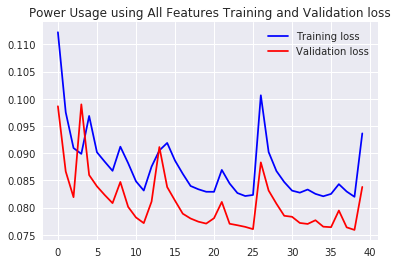

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


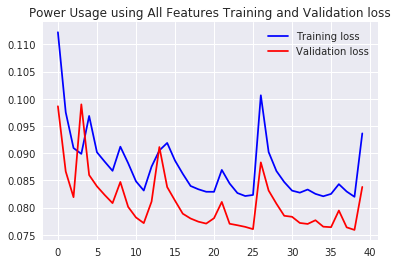

In [49]:
plot_train_history(multi_step_history_all_diff_power, 'Power Usage using All Features Training and Validation loss')

In [222]:
loss = multi_step_model_all_diff_power.evaluate(x_val_all_diff_power, y_val_all_diff_power, verbose=2)
print('Model error, MAE: {:5.4f}'.format(loss))

122/122 - 16s - loss: 0.0748
Model error, MAE: 0.0748


In [40]:
multi_step_model_all_diff_power.save('gpalldiffv2.h5')

Below are the plot of true future and predicted future of ten windown of model predict power usage using all other features. For some windown, the forecasted data are follow close to the true data.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


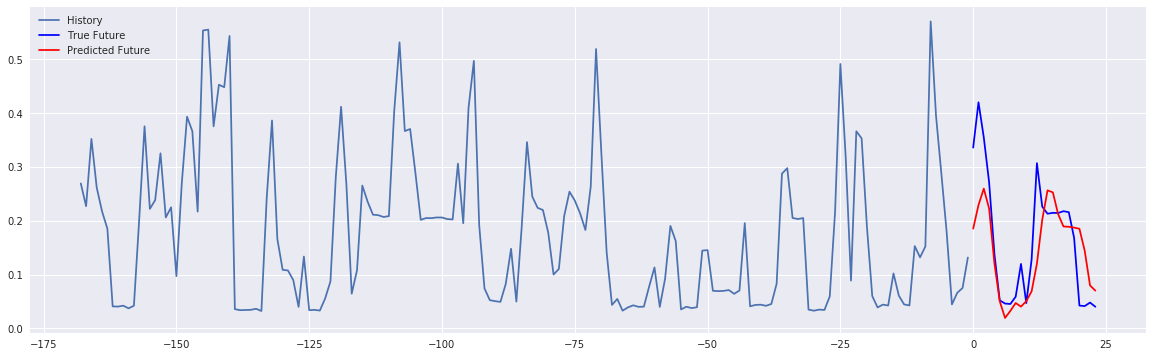

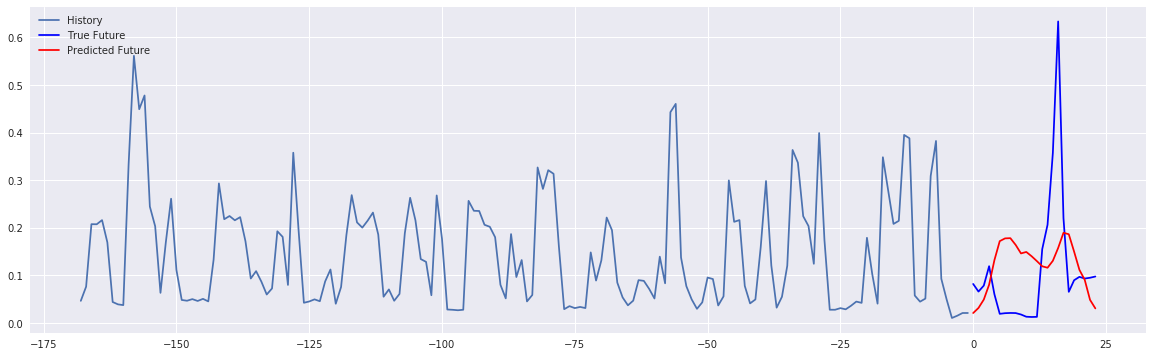

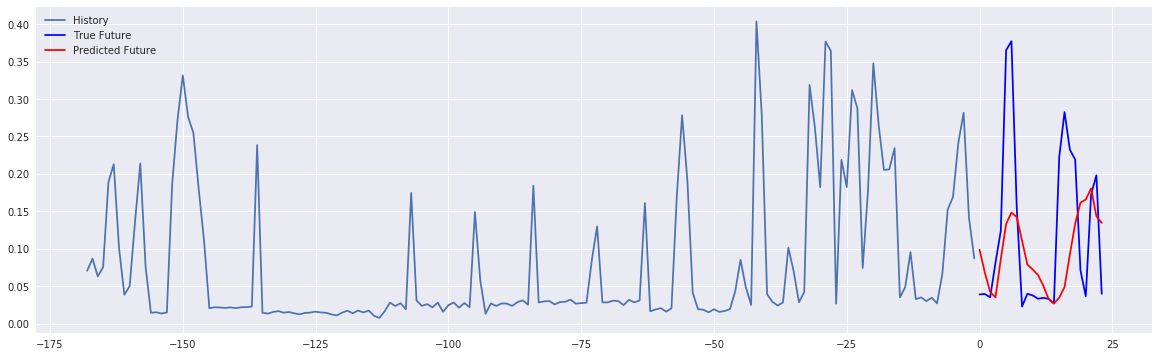

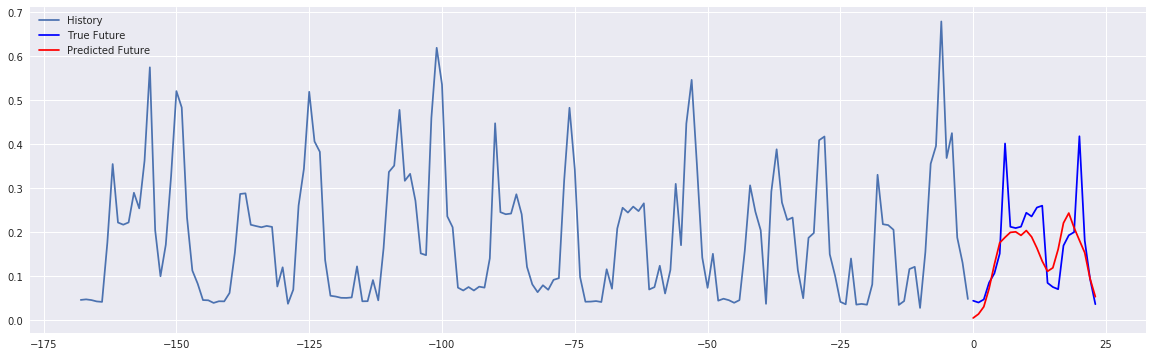

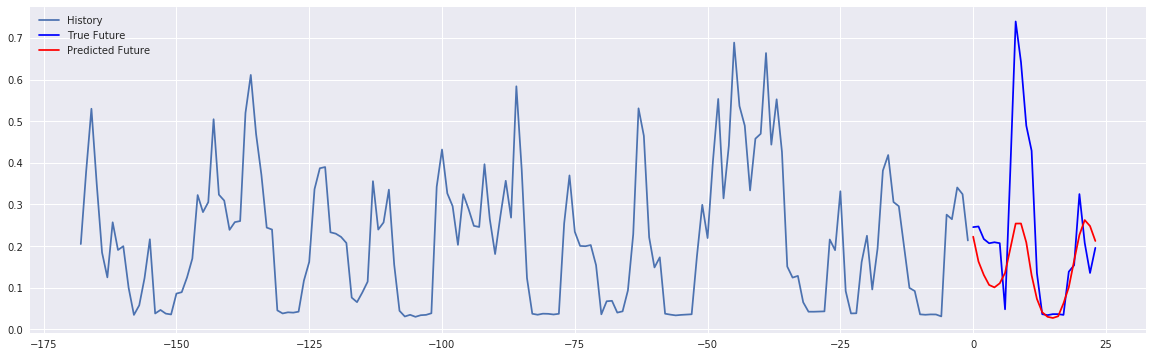

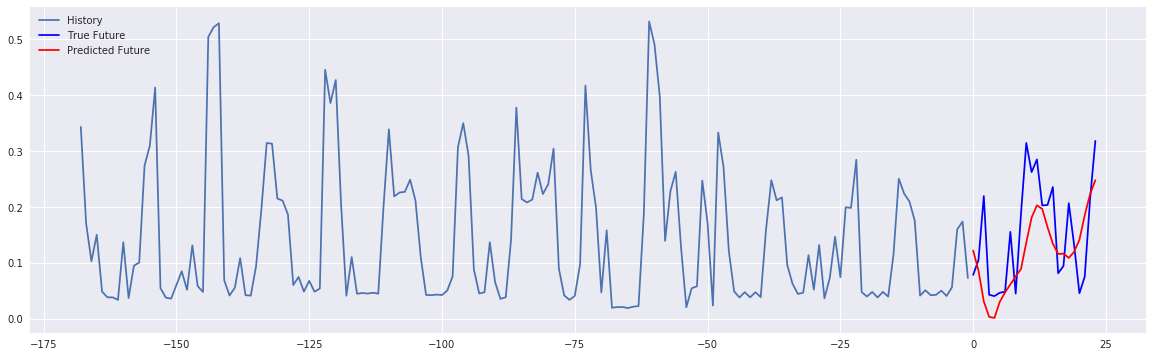

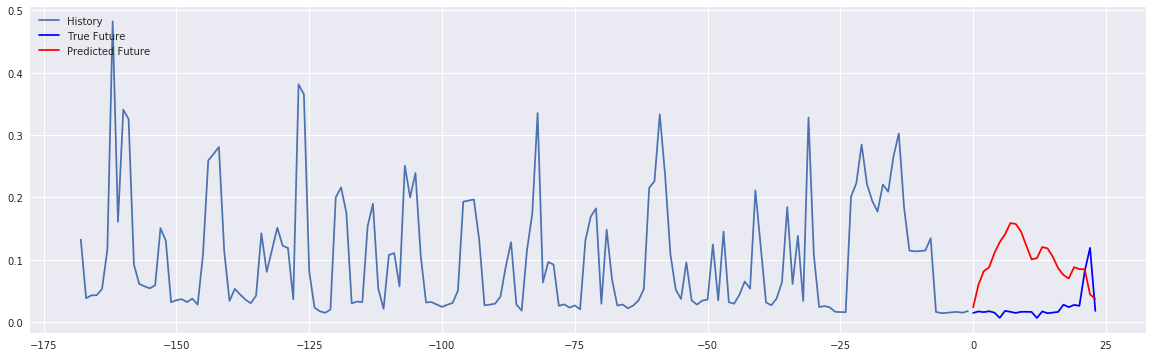

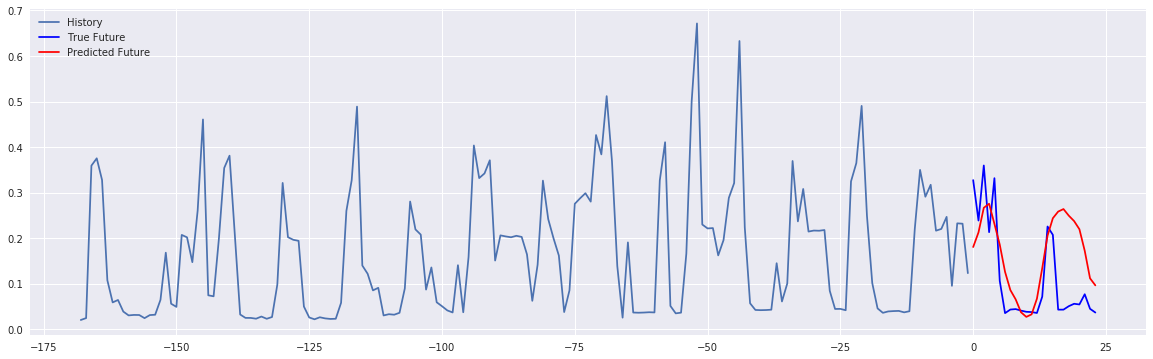

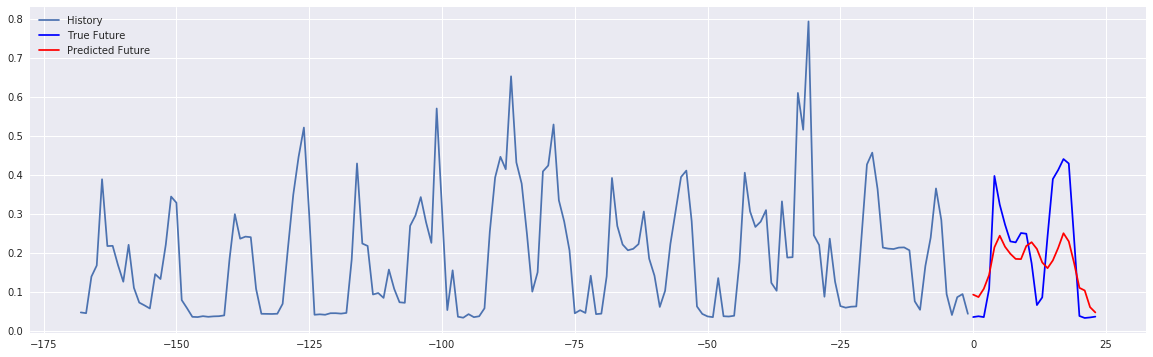

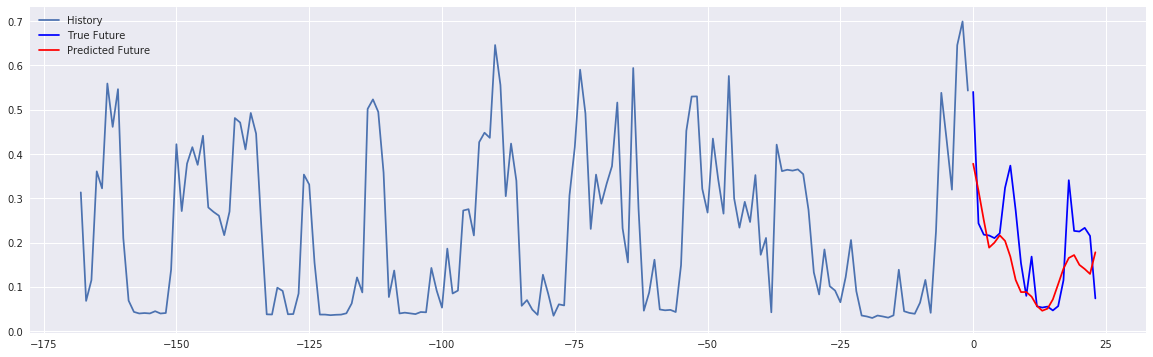

In [75]:
for x, y in val_data_multi_all_diff_power.take(10):
  multi_step_plot(x[0,:,7], y[0], multi_step_model_all_diff_power.predict(x)[0])

#Forecast GPI using all other features

In [43]:
x_train_all_gpi, y_train_all_gpi = multivariate_data(all_train_scaled, all_train_scaled[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_all_gpi, y_val_all_gpi = multivariate_data(all_train_scaled, all_train_scaled[:,0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [44]:
multi_step_model_all_gpi = create_model(input_shape=x_train_all_gpi.shape[-2:], horizon=future_target)

In [62]:
BATCH_SIZE = 250
BUFFER_SIZE = 10000
train_data_multi_all_gpi = tf.data.Dataset.from_tensor_slices((x_train_all_gpi, y_train_all_gpi))
train_data_multi_all_gpi = train_data_multi_all_gpi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_all_gpi = tf.data.Dataset.from_tensor_slices((x_val_all_gpi, y_val_all_gpi))
val_data_multi_all_gpi = val_data_multi_all_gpi.batch(BATCH_SIZE).repeat()

In [63]:
multi_step_history_all_gpi = multi_step_model_all_gpi.fit(train_data_multi_all_gpi, epochs=10,
                                                          steps_per_epoch=200,
                                                          use_multiprocessing=True,
                                                          validation_data=val_data_multi_all_gpi,
                                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 218s 1s/step - loss: 0.0782 - val_loss: 0.0739
Epoch 2/10
200/200 [==============================] - 216s 1s/step - loss: 0.0781 - val_loss: 0.0736
Epoch 3/10
200/200 [==============================] - 224s 1s/step - loss: 0.0784 - val_loss: 0.0744
Epoch 4/10
200/200 [==============================] - 272s 1s/step - loss: 0.0781 - val_loss: 0.0735
Epoch 5/10
200/200 [==============================] - 267s 1s/step - loss: 0.0777 - val_loss: 0.0746
Epoch 6/10
200/200 [==============================] - 244s 1s/step - loss: 0.0779 - val_loss: 0.0733
Epoch 7/10
200/200 [==============================] - 206s 1s/step - loss: 0.0778 - val_loss: 0.0736
Epoch 8/10
200/200 [==============================] - 202s 1s/step - loss: 0.0773 - val_loss: 0.0738
Epoch 9/10
200/200 [==============================] - 197s 985ms/step - loss: 0.0775 - val_loss: 0.0730
Epoch 10/10
200/200 [==============================] - 199s 994ms/step - loss: 0.0776 - 

In [ ]:
multi_step_model_all_gpi.save('gpiallv1.h5')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


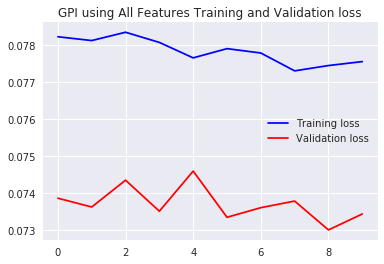

In [65]:
plot_train_history(multi_step_history_all_gpi, 'GPI using All Features Training and Validation loss')

In [67]:
multi_step_model_all_gpi.save('gpiallv1.h5')

The result below shows that using all other features to forecast the GPI is little bit better than using historical data of GPI itself. The loss error of validation data is smaller (0.073), compare to 0.077 in previous model of using only historiccal GPI data.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


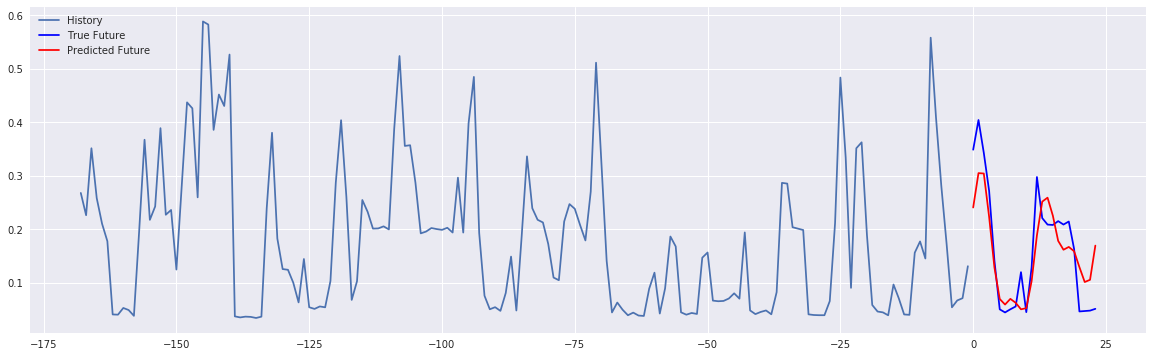

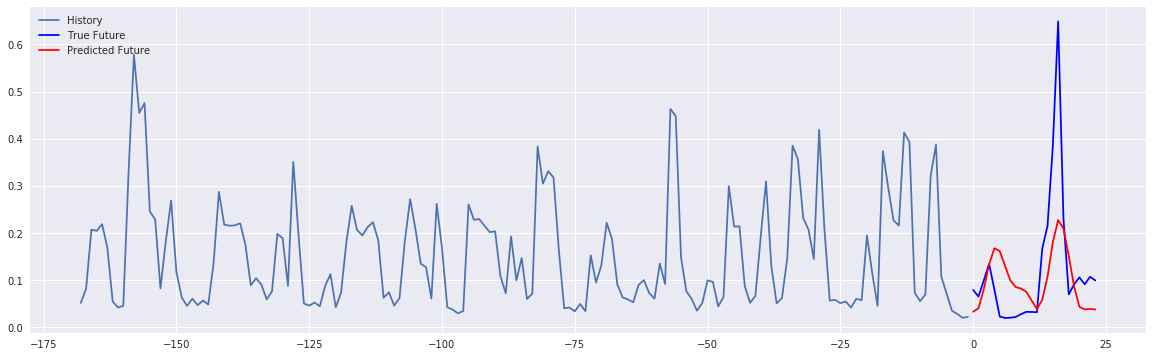

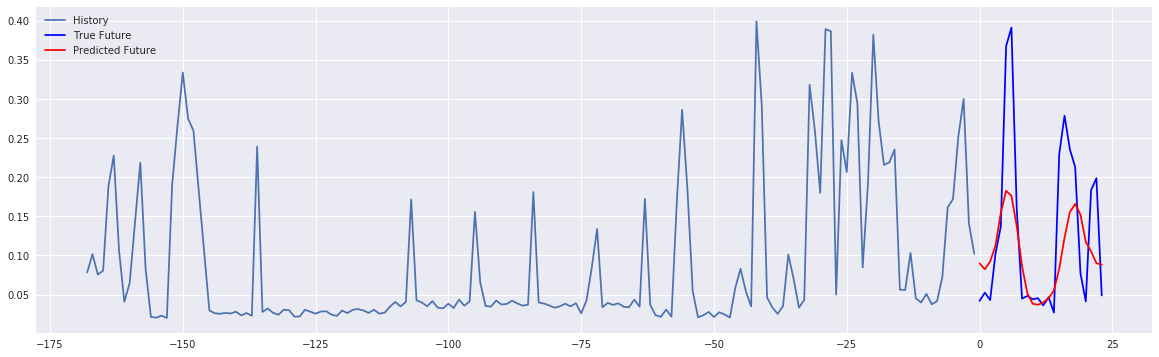

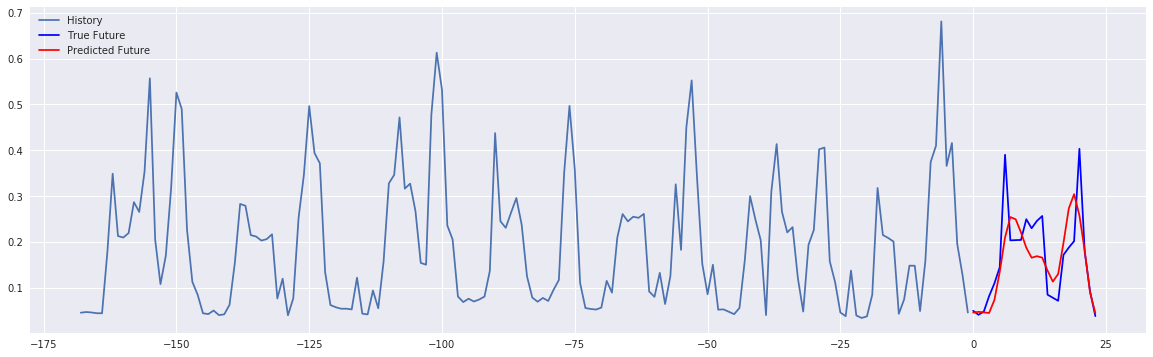

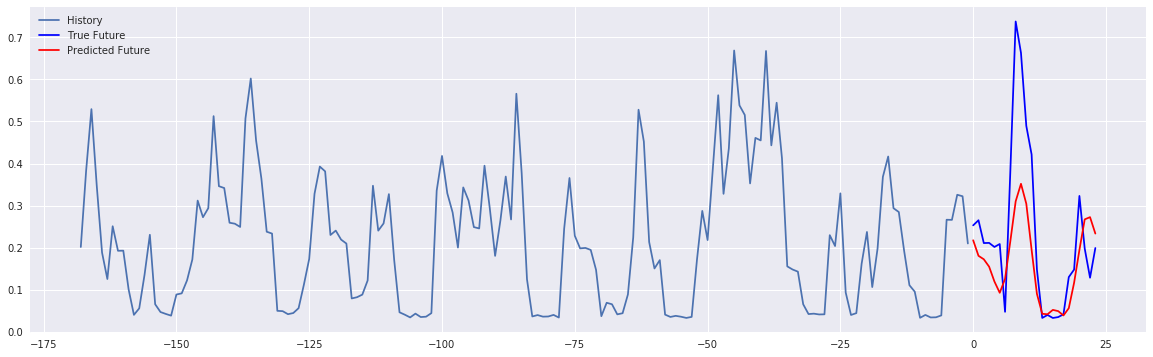

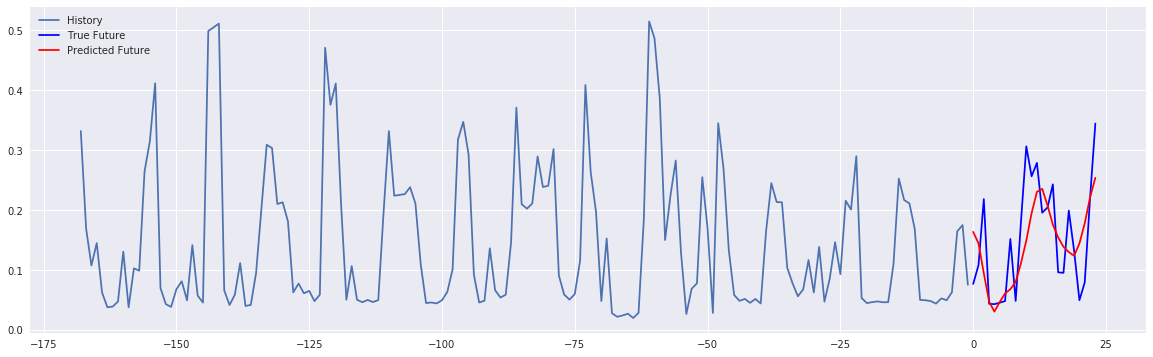

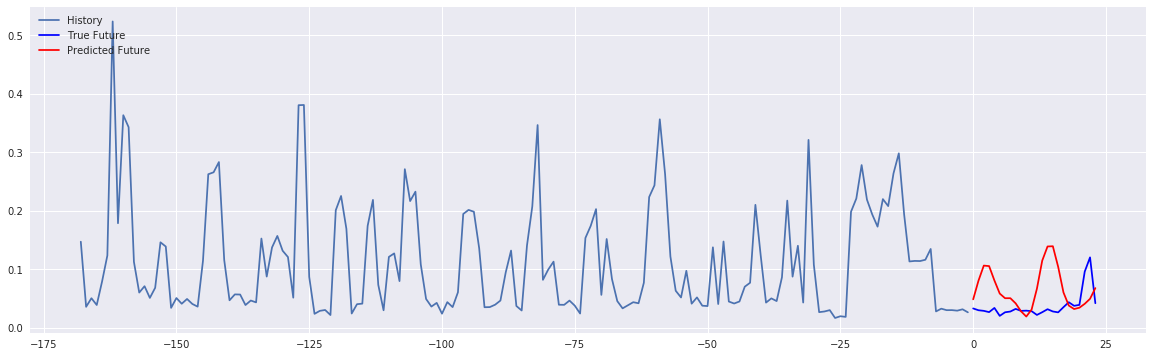

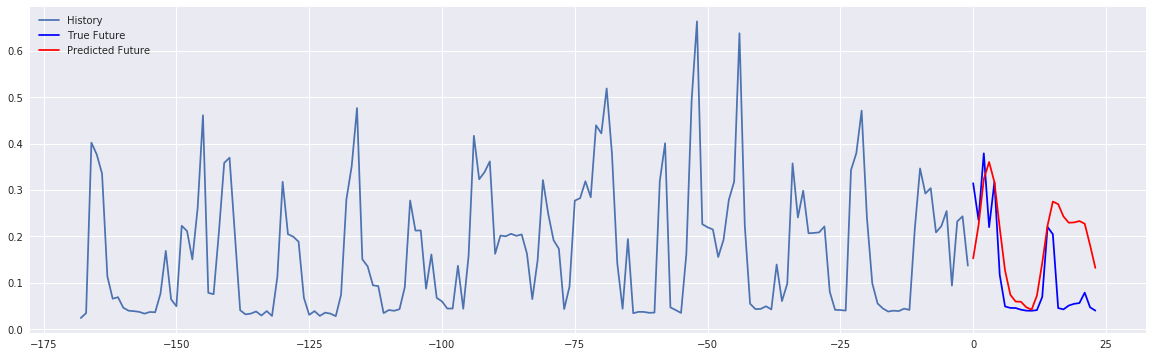

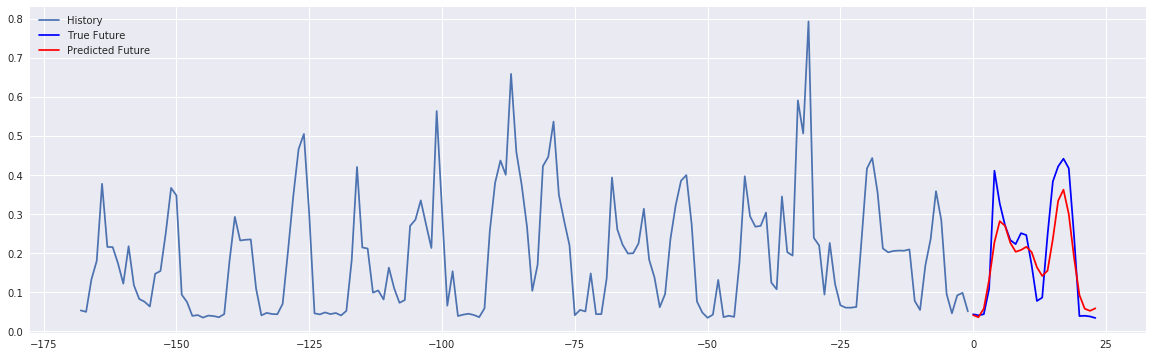

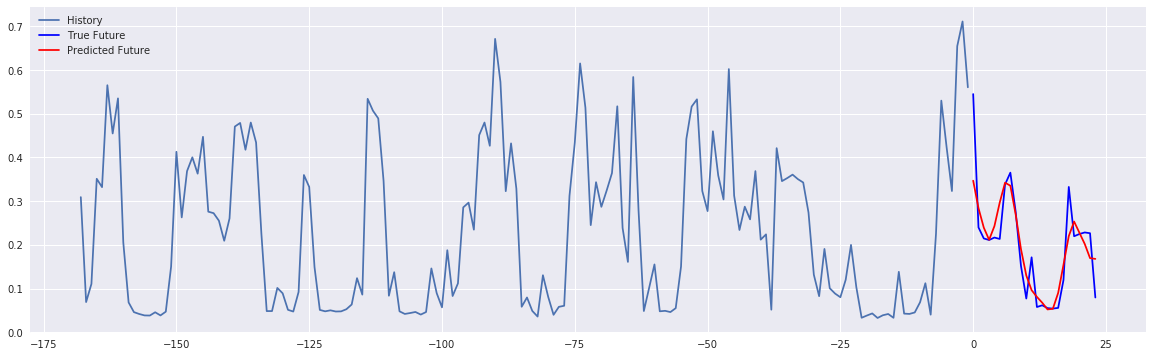

In [66]:
for x, y in val_data_multi_all_gpi.take(10):
  multi_step_plot(x[0,:,0], y[0], multi_step_model_all_gpi.predict(x)[0])